Number of tracks: 886
Pearson r: 0.30887977717494774 p-value: 4.8602271370883485e-21
Spearman rho: 0.36994189478097933 p-value: 4.03640435309153e-30


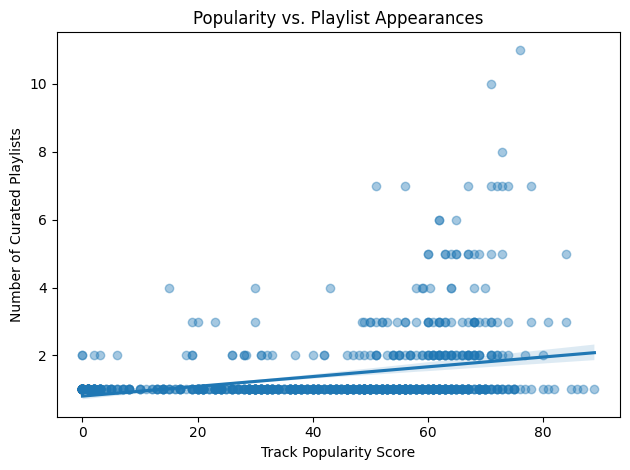

In [8]:
import json
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

data_path = Path("data/processed/afrobeats_playlists.json")

with data_path.open("r", encoding="utf-8") as f:
    root = json.load(f)

playlists = root["playlists"]
rows = []
for pl in playlists:
    for tr in pl["tracks"]:
        rows.append({
            "playlist_name": pl["name"],
            "track_id": tr["id"],
            "popularity": tr["trackPopularity"],
        })

df = pd.DataFrame(rows).dropna(subset=["track_id", "popularity", "playlist_name"])

playlist_counts = (
    df.groupby("track_id")["playlist_name"]
      .nunique()
      .rename("playlist_appearances")
)

track_popularity = (
    df.groupby("track_id")["popularity"]
      .mean()
      .rename("popularity_score")
)

track_stats = pd.concat([track_popularity, playlist_counts], axis=1).dropna()

x = track_stats["popularity_score"]
y = track_stats["playlist_appearances"]

pearson_r, pearson_p = pearsonr(x, y)
spearman_rho, spearman_p = spearmanr(x, y)

print("Number of tracks:", len(track_stats))
print("Pearson r:", pearson_r, "p-value:", pearson_p)
print("Spearman rho:", spearman_rho, "p-value:", spearman_p)

sns.regplot(
    data=track_stats,
    x="popularity_score",
    y="playlist_appearances",
    scatter_kws={"alpha": 0.4}
)
plt.xlabel("Track Popularity Score")
plt.ylabel("Number of Curated Playlists")
plt.title("Popularity vs. Playlist Appearances")
plt.tight_layout()
plt.show()

In [9]:
import statsmodels.formula.api as smf

# Start from track_stats-like table but with extra columns
# Rebuild a per-track dataset including predictors
rows = []
for pl in playlists:
    for tr in pl["tracks"]:
        rows.append({
            "track_id": tr["id"],
            "trackPopularity": tr["trackPopularity"],
            "regionGroup": tr["regionGroup"],
            "diaspora": tr["diaspora"],
            "labelType": tr["labelType"],  # or albumLabel, pick one
            "releaseYear": tr["releaseYear"],
        })

reg_df = pd.DataFrame(rows).dropna(subset=[
    "track_id", "trackPopularity", "regionGroup",
    "diaspora", "labelType", "releaseYear"
])

# Aggregate to one row per track (mean across playlists if duplicated)
reg_df = (
    reg_df
    .groupby("track_id", as_index=False)
    .agg({
        "trackPopularity": "mean",
        "regionGroup": "first",
        "diaspora": "first",
        "labelType": "first",
        "releaseYear": "first",
    })
)

# Convert categorical variables
reg_df["diaspora"] = reg_df["diaspora"].astype(int)  # 1/0
reg_df["regionGroup"] = reg_df["regionGroup"].astype("category")
reg_df["labelType"] = reg_df["labelType"].astype("category")

# Multiple linear regression with region and label as categorical (dummy) vars
formula = (
    "trackPopularity ~ releaseYear + diaspora "
    "+ C(regionGroup) + C(labelType)"
)

model = smf.ols(formula=formula, data=reg_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        trackPopularity   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     7.185
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.96e-14
Time:                        00:27:43   Log-Likelihood:                -3995.0
No. Observations:                 886   AIC:                             8020.
Df Residuals:                     871   BIC:                             8092.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [10]:
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the same dataset used by analyze_bias.py
data_path = Path("data/processed/afrobeats_playlists.json")
with data_path.open("r", encoding="utf-8") as f:
    payload = json.load(f)

rows = []
for playlist in payload.get("playlists", []):
    for track in playlist.get("tracks") or []:
        rows.append({
            "playlist_id": playlist.get("id"),
            "playlist_name": playlist.get("name"),
            "curator_type": playlist.get("curatorType"),
            "track_id": track.get("id"),
            "artist": track.get("artist"),
            "artist_country": track.get("artistCountry", "Unknown") or "Unknown",
            "region_group": track.get("regionGroup", "Unknown") or "Unknown",
            "diaspora": bool(track.get("diaspora")),
            "release_year": track.get("releaseYear"),
            "track_popularity": track.get("trackPopularity"),
            "artist_popularity": track.get("artistPopularity"),
            "artist_followers": track.get("artistFollowers"),
            "playlist_position": track.get("playlistPosition"),
            "label_type": track.get("labelType") or track.get("label_type"),
            "album_label": track.get("albumLabel"),
        })

df_bias = pd.DataFrame(rows)
df_bias["release_year"] = pd.to_numeric(df_bias["release_year"], errors="coerce")
df_bias["track_popularity"] = pd.to_numeric(df_bias["track_popularity"], errors="coerce")
df_bias["artist_popularity"] = pd.to_numeric(df_bias["artist_popularity"], errors="coerce")
df_bias["artist_followers"] = pd.to_numeric(df_bias["artist_followers"], errors="coerce")
df_bias["playlist_position"] = pd.to_numeric(df_bias["playlist_position"], errors="coerce")
df_bias["label_type"] = df_bias["label_type"].fillna("Unknown")

df_bias.head()

,playlist_id,playlist_name,curator_type,track_id,artist,artist_country,region_group,diaspora,release_year,track_popularity,artist_popularity,artist_followers,playlist_position,label_type,album_label
0,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,7od7AQDGyj8mM44djQpBGW,"Mack H.D, Bolu Ajibade",Haiti/USA,North America,True,2023,57,55,20737,1,Unknown,Unknown
1,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,5aIVCx5tnk0ntmdiinnYvw,Tyla,South Africa,Southern Africa,False,2023,84,80,3711204,2,Unknown,Unknown
2,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,3baPniPXS0iEII8rDUJdYP,"Lojay, Sarz, Chris Brown",Nigeria,West Africa,False,2022,72,63,868644,3,Unknown,Unknown
3,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,1xs8bOvm3IzEYmcLJVOc34,Ayra Starr,Nigeria,West Africa,False,2022,72,76,5840297,4,Unknown,Unknown
4,afrobeats-hits,Afrobeats Hits 🔥,Independent Curator,0JHiAVySqpLE1RpBMkZnau,"Mack H.D, Tmaro",Haiti/USA,North America,True,2025,54,55,20737,5,Unknown,Unknown


Regional representation
Chi-square = 225.47, df = 36, p-value = 0.0000


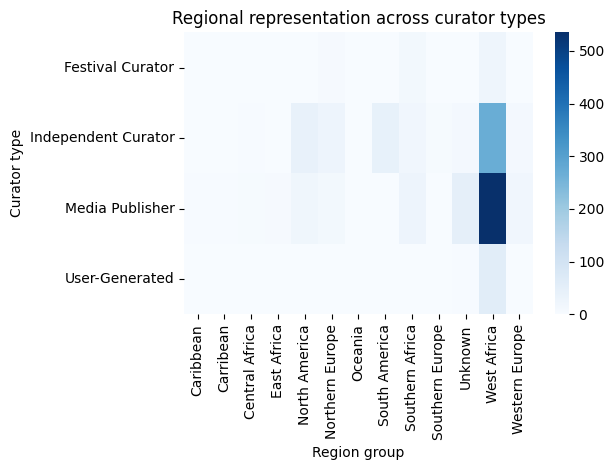


Label representation
Chi-square = 0.00, df = 0, p-value = 1.0000


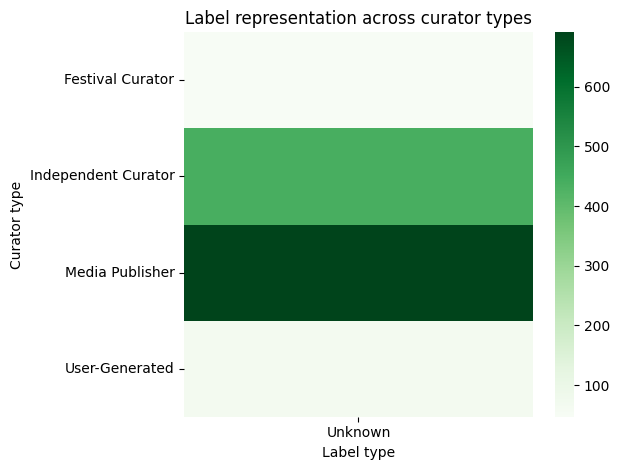


Track popularity across curator types
ANOVA F = 21.76, p = 0.0000
Kruskal-Wallis H = 38.89, p = 0.0000


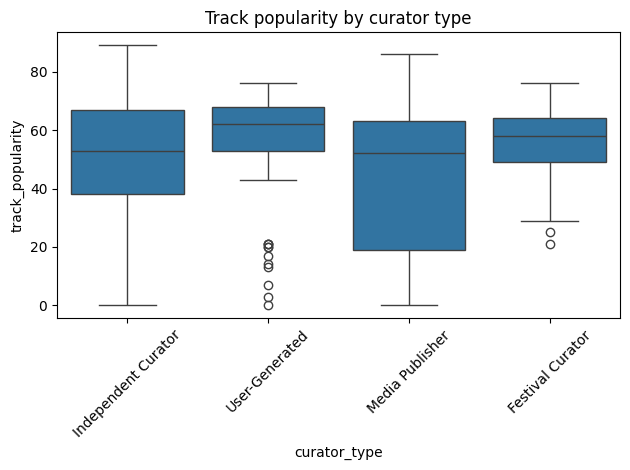


Artist popularity across curator types
ANOVA F = 22.43, p = 0.0000
Kruskal-Wallis H = 27.24, p = 0.0000


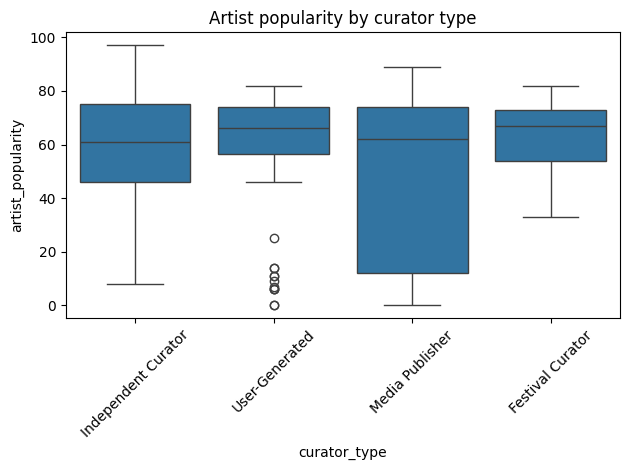


Artist follower counts across curator types
ANOVA F = 1.78, p = 0.1493
Kruskal-Wallis H = 16.72, p = 0.0008


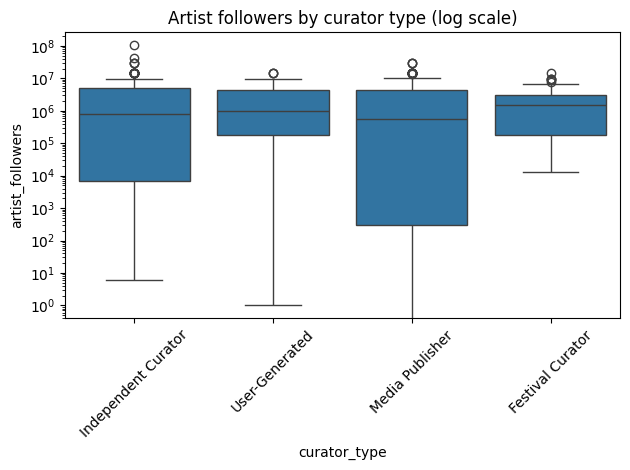


Release year across curator types
ANOVA F = 8.11, p = 0.0000
Kruskal-Wallis H = 121.65, p = 0.0000


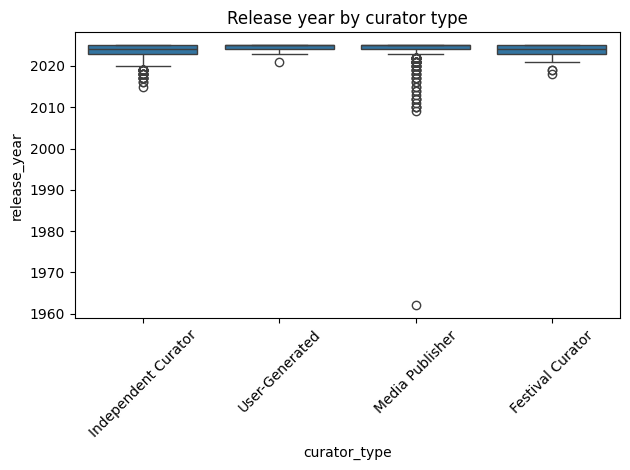


Top recurring artists
                    artist  playlist_count
0                     Rema              13
1         Davido, Omah Lay              11
2                Burna Boy              11
3    Shallipopi, Burna Boy              10
4                    Asake               9
5  Burna Boy, Travis Scott               8
6               Ayra Starr               8
7   DJ Tunez, Wizkid, FOLA               7
8          Olamide, Wizkid               7
9       Ayra Starr, Wizkid               7


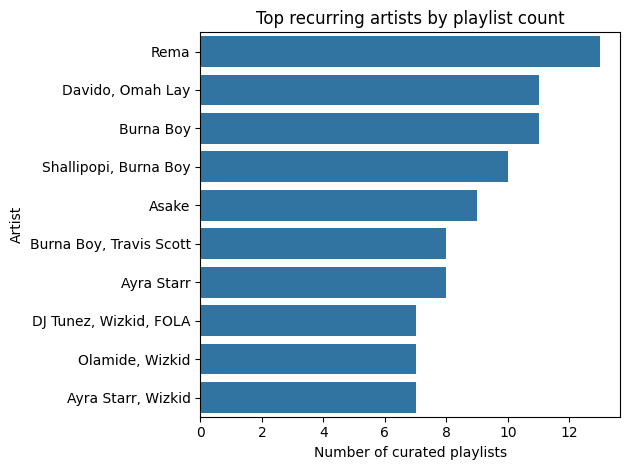

In [14]:
from scipy.stats import chi2_contingency, f_oneway, kruskal
import numpy as np

# Regional representation: chi-square
cont_region = pd.crosstab(df_bias["curator_type"], df_bias["region_group"])
chi2_region, p_region, dof_region, _ = chi2_contingency(cont_region)
print("Regional representation")
print(f"Chi-square = {chi2_region:.2f}, df = {dof_region}, p-value = {p_region:.4f}")

sns.heatmap(cont_region, annot=False, cmap="Blues")
plt.title("Regional representation across curator types")
plt.ylabel("Curator type")
plt.xlabel("Region group")
plt.tight_layout()
plt.show()

# Label representation: chi-square
cont_label = pd.crosstab(df_bias["curator_type"], df_bias["label_type"])
chi2_label, p_label, dof_label, _ = chi2_contingency(cont_label)
print("\nLabel representation")
print(f"Chi-square = {chi2_label:.2f}, df = {dof_label}, p-value = {p_label:.4f}")

sns.heatmap(cont_label, annot=False, cmap="Greens")
plt.title("Label representation across curator types")
plt.ylabel("Curator type")
plt.xlabel("Label type")
plt.tight_layout()
plt.show()

# Helper to run ANOVA + Kruskal
def run_anova_kruskal(series, groups, label: str):
    mask = series.notna() & groups.notna()
    values = series[mask]
    g = groups[mask]
    grouped = [values[g == cat] for cat in g.unique()]
    grouped = [v for v in grouped if len(v) >= 3]
    if len(grouped) < 2:
        print(f"\n{label}: not enough data for tests")
        return
    f_stat, p_anova = f_oneway(*grouped)
    h_stat, p_kruskal = kruskal(*grouped)
    print(f"\n{label}")
    print(f"ANOVA F = {f_stat:.2f}, p = {p_anova:.4f}")
    print(f"Kruskal-Wallis H = {h_stat:.2f}, p = {p_kruskal:.4f}")

# Track popularity across curator types
run_anova_kruskal(df_bias["track_popularity"], df_bias["curator_type"], "Track popularity across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="track_popularity")
plt.xticks(rotation=45)
plt.title("Track popularity by curator type")
plt.tight_layout()
plt.show()

# Artist popularity across curator types
run_anova_kruskal(df_bias["artist_popularity"], df_bias["curator_type"], "Artist popularity across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="artist_popularity")
plt.xticks(rotation=45)
plt.title("Artist popularity by curator type")
plt.tight_layout()
plt.show()

# Artist follower counts across curator types
run_anova_kruskal(df_bias["artist_followers"], df_bias["curator_type"], "Artist follower counts across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="artist_followers")
plt.yscale("log")
plt.xticks(rotation=45)
plt.title("Artist followers by curator type (log scale)")
plt.tight_layout()
plt.show()

# Release year across curator types
run_anova_kruskal(df_bias["release_year"], df_bias["curator_type"], "Release year across curator types")
sns.boxplot(data=df_bias, x="curator_type", y="release_year")
plt.xticks(rotation=45)
plt.title("Release year by curator type")
plt.tight_layout()
plt.show()

# Top recurring artists
top_artists = (
    df_bias.groupby("artist")["playlist_id"].nunique()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name="playlist_count")
)
print("\nTop recurring artists")
print(top_artists)

sns.barplot(data=top_artists, x="playlist_count", y="artist", orient="h")
plt.xlabel("Number of curated playlists")
plt.ylabel("Artist")
plt.title("Top recurring artists by playlist count")
plt.tight_layout()
plt.show()


In [12]:
print("Raw df_bias rows:", len(df_bias))
print("Unique playlists:", df_bias["playlist_id"].nunique())
print("Unique tracks:", df_bias["track_id"].nunique())
print("Unique artists:", df_bias["artist"].nunique())

# Non-null popularity rows
print("Non-null track_popularity rows:", df_bias["track_popularity"].notna().sum())
print("Non-null artist_popularity rows:", df_bias["artist_popularity"].notna().sum())
print("Non-null artist_followers rows:", df_bias["artist_followers"].notna().sum())

Raw df_bias rows: 1241
Unique playlists: 14
Unique tracks: 886
Unique artists: 690
Non-null track_popularity rows: 1241
Non-null artist_popularity rows: 1241
Non-null artist_followers rows: 1241
